In [1]:
cd /Users/cl1704/PycharmProjects/clustering_in_rnns

/Users/cl1704/PycharmProjects/clustering_in_rnns


In [2]:

from Experiment_1.TwoAFCTask import generate_trials
from Experiment_1.net import *
import pandas as pd
from scipy.stats import ortho_group
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import os
import scipy.optimize as opt
import math
#from psychometrics import *
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import networkx as nx
from sklearn.cluster import KMeans
from scipy.stats import special_ortho_group
plt.rcParams["axes.grid"] = False
matplotlib.rcParams['axes.linewidth'] = 1

In [3]:
def compute_var(variance,n):
    return np.sum(variance[n:])

In [42]:
df_list = []
for filename in os.listdir('Experiment_1/Results_1'):
    f = os.path.join('Experiment_1/Results_1', filename)
    if os.path.isfile(f):
        df_list.append(pd.read_pickle(f))
original_df = pd.concat(df_list,ignore_index=True) 
original_df = original_df[original_df.mse_z<.035]
original_df = original_df[original_df.lambda_std==0.1]
original_df = original_df[original_df.activity_std<.01]
original_df = original_df[original_df.sigma_rec==0.1]

# Trial data for simulations
u, z, mask, conditions  = generate_trials(
                                    n_trials=25)
palette = sns.color_palette("husl", n_colors=50,as_cmap=False)




# Load data for row
df =original_df.copy()
dim = 2
k=2
df  = df[df.dim==dim]
df = df[df.k>=dim]
df['k_inertia'] = df.inertia.apply(lambda x: x[k-1])
df['var'] = df.variance.apply(lambda x: compute_var(x,dim))
#df['var'] = np.log(df['var'])
df = df.sort_values('var',ascending=True)
#bins = np.linspace(-3,-.75,9)

# 


7873    2
Name: k, dtype: int64


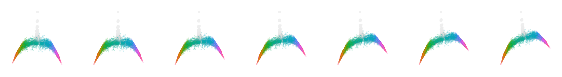

In [66]:

model_id = df.model_id.values[0]
#model_id  = df[ (df['mean'] ==bin_means[col] )].sort_values('var')['model_id'].values[1]
model_data = df[df.model_id==model_id]
print(model_data['k'])
# Simulate model
net = Net(n=100,input_size = 2,dale=False)
net.recurrent_layer.weight.data = torch.tensor(model_data['w_rec'].item())
net.recurrent_layer.bias.data = torch.tensor(model_data['bias'].item())
net.input_layer.weight.data = torch.tensor(model_data['w_in'].item())
net.output_layer.weight.data = torch.tensor(model_data['w_out'].item())
net.sigma_in=0.1
palette = sns.color_palette("husl", n_colors=50,as_cmap=False)
x = net(u)
x = x - torch.mean(x,dim=(0,1),keepdims=True)
pca = PCA()
pca.fit(x[:,:,:].detach().numpy().reshape(-1, x.shape[2]))

n_steps = 7
dim = 10
fig = plt.figure(figsize=(7,.75))
gs = gridspec.GridSpec(1,7,wspace=.5)

#bins = [0,.025,.05,.1,.2,.3,.4,.5,.6]
a0 = np.zeros((dim,dim))
a1 = .4*np.random.rand(dim,dim)
skew_0 = (a0 - a0.T) / 2
skew_1 = (a1 - a1.T) / 2
for col in range(n_steps):
    # Create axis
    ax=fig.add_subplot(gs[0,col])
    
    # One parameter family of rotations
    
    params = np.linspace(0,1,n_steps)
    skew = skew_0 + params[col]*(skew_1-skew_0)
    eye = np.eye(dim)
    o = (eye - skew) @ np.linalg.inv(eye + skew)
    o = pca.components_[:dim,:].T @ o @ pca.components_[:dim,:]
    x_rot =  x @ torch.tensor(o).float()
    x_proj = pca.transform(x_rot.detach().numpy().reshape(-1, x.shape[2])).reshape(x.shape[0],x.shape[1],100)
            
    #rot = ortho_group.rvs(3)
    
    rows = []
    for k in range(u.shape[0]):
        for t in range(u.shape[1]):
            rows.append({'trial':k,
                         'motion':conditions[k]['motion_coh'],
                        't':t,
                        'z_1':x_proj[k,t,0],
                        'z_2':x_proj[k,t,1],
                         'z_3':x_proj[k,t,2]})
    new_df = pd.DataFrame(rows)
    new_df_mean =new_df.groupby(['motion','t']).mean().reset_index()
    
    # new_df =new_df
    # sns.scatterplot(data=new_df[new_df.t==74],x='z_1',y='z_2',hue='motion',ax=ax,legend=False,s=.5,alpha=.1,palette = palette,edgecolor=None)
    # 
    # sns.scatterplot(data=new_df_mean[new_df_mean.t==74],x='z_1',y='z_2',hue='motion',ax=ax,legend=False,s=1,alpha=1,palette = palette,edgecolor=None)
    palette = sns.husl_palette(n_colors = 50,s=1)
    # sns.scatterplot(data=new_df,x='z_1',y='z_2',hue='t',ax=ax,legend=False,s=1,alpha=1,palette = sns.blend_palette(["lightgray", "gray"], as_cmap=True),edgecolor=None)
    sns.scatterplot(data=new_df_mean,x='z_1',y='z_2',hue='t',ax=ax,legend=False,s=.75,alpha=1,palette = sns.light_palette("gray",as_cmap=True),edgecolor=None)
    sns.scatterplot(data=new_df_mean[new_df_mean.t>70],x='z_1',y='z_2',hue='motion',ax=ax,legend=False,s=2,alpha=1,palette = palette,edgecolor=None)
    sns.scatterplot(data=new_df[new_df.t>70],x='z_1',y='z_2',hue='motion',ax=ax,legend=False,s=.25,alpha=.5,palette = palette,edgecolor=None)

    
    # Make axis pretty
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_xlabel("PC 1",fontsize=6)
    ax.set_ylabel("PC 2",fontsize=6)
    #ax.set_title(r'$\sum_{i\geq 2}\lambda_i = $'+str(np.round(variance,4)),fontsize=8)
    ax.xaxis.set_tick_params(labelsize=6,bottom=False)
    ax.yaxis.set_tick_params(labelsize=6,left=False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    #ax.set_xlim(-1,1)
    #ax.set_ylim(-1,1)
 #    if row ==0:
     #        ax.text(.5,-.2,r'$\sum_{i>2}\lambda_i=$'+' '+str(np.round(np.sum(pca.explained_variance_ratio_[row+2:]),3)), horizontalalignment='center',
     # verticalalignment='center', transform=ax.transAxes,fontsize = 4)
     #    if row ==1:
     #        ax.text(.5,-.2,r'$\sum_{i>3}\lambda_i=$'+' '+str(np.round(np.sum(pca.explained_variance_ratio_[row+2:]),3)), horizontalalignment='center',
     # verticalalignment='center', transform=ax.transAxes,fontsize = 4)
     #    if row == 2:
     #        ax.text(.5,-.2,r'$\sum_{i>4}\lambda_i=$'+' '+str(np.round(np.sum(pca.explained_variance_ratio_[row+2:]),3)), horizontalalignment='center',
     # verticalalignment='center', transform=ax.transAxes,fontsize = 4)
        
fig.savefig('Figures/SIFig_2afcmanifolds.jpg',
    format='jpeg',
    dpi=450,
            bbox_inches='tight')


0.0001756365038617782
0.003605678040065101
0.013325044937004564
0.02894351782031429
0.04989351505933106
0.06944093406491295
0.09137686361695987


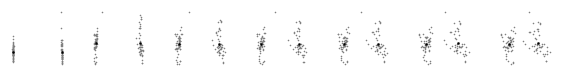

In [69]:
fig = plt.figure(figsize=(7,.75))
gs = gridspec.GridSpec(1,n_steps,wspace = .5)

#bins = [0,.025,.05,.1,.2,.3,.4,.5,.6]
for col in range(n_steps):
    # Create axis
    ax=fig.add_subplot(gs[0,col])
    
    # One parameter family of rotations
    a0 = np.zeros((dim,dim))
    #a1 = .1*np.random.rand(dim,dim)
    skew_0 = (a0 - a0.T) / 2
    skew_1 = (a1 - a1.T) / 2
    params = np.linspace(0,1,n_steps)
    skew = skew_0 + params[col]*(skew_1-skew_0)
    eye = np.eye(dim)
    o = (eye - skew) @ np.linalg.inv(eye + skew)
    o = pca.components_[:dim,:].T @ o @ pca.components_[:dim,:]
    x_rot =  x @ torch.tensor(o).float()
    x_rot =x_rot.detach().cpu().numpy()
   # x_proj = pca.transform(x.detach().numpy().reshape(-1, x.shape[2])).reshape(x.shape[0],x.shape[1],3)
    rows = []
    for k in range(u.shape[0]):
        rows.append({'trial': k,
                     'motion': conditions[k]['motion_coh'],
                     'response': x_rot[k, :, :]})
    new_df = pd.DataFrame(rows)
    new_df = new_df.groupby(['motion']).response.apply(lambda r: np.mean(np.stack(r), axis=0)).reset_index()
    
    #df = df.groupby('motion').response.apply(lambda r: np.mean(np.stack(r), axis=0)).reset_index()
    responses = np.stack(new_df.response.values)
    responses = responses.reshape(-1, responses.shape[2]).T
    
    #responses = responses[np.mean(responses, axis=1) >.15, :]
    
    # z_score
    # responses = (responses - np.mean(responses, axis=1, keepdims=True)) / np.std(responses, axis=1, keepdims=True)
    # responses = responses[~np.isnan(responses).any(axis=1)]
    
    
    
    #responses = .001 * (2*np.random.rand(responses.shape[0],responses.shape[1])-1)
    total_variance = np.sum((responses.T - np.mean(responses.T, axis=0, keepdims=True)) ** 2)

    clustering = KMeans(n_clusters=2,n_init='auto').fit(responses)
    labels  = clustering.labels_
    print(clustering.inertia_/total_variance)

    #responses  = responses + .5*(2*np.random.rand(responses.shape[0],responses.shape[1])-1)
    
    X = responses
    y = labels
   # lda = LinearDiscriminantAnalysis(solver='eigen',  shrinkage=9e-1)
    lda = PCA()
    # parameters = {'tol':10**np.linspace(-2,-.5,25)}
    # from sklearn.model_selection import GridSearchCV
    # clf = GridSearchCV(lda, parameters,refit=True,error_score = np.nan,cv=5)
    # clf.fit(X, y)
    # lda = clf.best_estimator_
    x_proj = lda.fit_transform(X)
    

        
    centers_proj = lda.transform(clustering.cluster_centers_)
    #scale = np.sum(PCA().fit(centers_proj).explained_variance_[:2])/100
   
    
    
    #x_proj = x_proj + 1*(2*np.random.rand(x_proj.shape[0],x_proj.shape[1])-1)
    network_pal = sns.husl_palette(pd.Series(np.sort(labels)).unique().size,s=1)
    
    lut = dict(zip(pd.Series(np.sort(labels)).unique(),network_pal))
    row_colors = pd.Series(np.sort(labels)).map(lut)
    
    sns.scatterplot(x=x_proj[np.argsort(labels), 0], y=x_proj[np.argsort(labels), 1], color='gray',s=1,alpha=1,ax=ax,edgecolor=None)
    sns.scatterplot(x=centers_proj[:, 0], y=centers_proj[:, 1], color='k',s=3,alpha=1,ax=ax,edgecolor=None)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_xlabel("PC 1",fontsize=6)
    ax.set_ylabel("PC 2",fontsize=6)
    #ax.set_title(r'$\sum_{i\geq 2}\lambda_i = $'+str(np.round(variance,4)),fontsize=8)
    #ax.xaxis.set_tick_params(labelsize=6,bottom=False)
    #ax.yaxis.set_tick_params(labelsize=6,left=False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    #ax.set_aspect('equal', adjustable='box')
    #ax.set_xlim(-5,5)
    #ax.set_ylim(-1,1)
    fig.savefig('Figures/SIFig_2afcmanifolds_2.jpg',
    format='jpeg',
    dpi=450,
            bbox_inches='tight')

In [53]:
responses.shape

(100, 675)

In [51]:
conditions[k]['motion_coh']

-0.125

In [50]:
model_df

,trial,motion,response
0,0,0.0625,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,0.0000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2,-0.2500,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,3,0.0625,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,4,0.0625,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...
895,895,0.1250,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
896,896,-0.2500,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
897,897,-0.2500,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
898,898,-0.2500,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [43]:
conditions

[{'motion_coh': -1.0, 'correct_choice': -1},
 {'motion_coh': -1.0, 'correct_choice': -1},
 {'motion_coh': 0.0625, 'correct_choice': 1},
 {'motion_coh': 0.0, 'correct_choice': -1},
 {'motion_coh': 1.0, 'correct_choice': 1},
 {'motion_coh': 0.125, 'correct_choice': 1},
 {'motion_coh': -0.0625, 'correct_choice': -1},
 {'motion_coh': -0.125, 'correct_choice': -1},
 {'motion_coh': 1.0, 'correct_choice': 1},
 {'motion_coh': -1.0, 'correct_choice': -1},
 {'motion_coh': 0.25, 'correct_choice': 1},
 {'motion_coh': 0.0, 'correct_choice': -1},
 {'motion_coh': -0.0625, 'correct_choice': -1},
 {'motion_coh': 1.0, 'correct_choice': 1},
 {'motion_coh': -0.0625, 'correct_choice': -1},
 {'motion_coh': -1.0, 'correct_choice': -1},
 {'motion_coh': 1.0, 'correct_choice': 1},
 {'motion_coh': 0.25, 'correct_choice': 1},
 {'motion_coh': -0.25, 'correct_choice': -1},
 {'motion_coh': 0.125, 'correct_choice': 1},
 {'motion_coh': -0.25, 'correct_choice': -1},
 {'motion_coh': -0.0625, 'correct_choice': -1},
 {'mo

In [42]:
model_df

,motion,response
0,0.25,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [31]:
x_proj.shape

(900, 75, 3)

In [28]:
x_proj.shape

(900, 75, 100)

In [19]:
rot.shape

(100, 100)

In [6]:
def compute_k(responses,n_init,max_clusters,threshold):
    inertia = []
    for n_clusters in range(1, np.min([max_clusters,responses.shape[0]])):
        kmeans = KMeans(n_clusters=n_clusters,n_init=n_init).fit(responses)
        inertia.append(kmeans_r2(kmeans,responses))
    #inertia = -np.diff(inertia)

    for j in range(len(inertia)):
        if inertia[j] < threshold:
            break
    k = j + 1
    return inertia, k

# Function for computing r2 for kmeans model
def kmeans_r2(kmeans, responses ):
    n_neurons = responses.shape[0]
    cluster_means = kmeans.cluster_centers_
    n_clusters = cluster_means.shape[0]
    Q = np.zeros((n_neurons,n_clusters))
    for i in range(n_clusters):
        Q[kmeans.labels_ ==i, i] = 1

    prediction  = Q @ cluster_means
    squared_error  = np.sum((prediction - responses)**2)
    total_variance = np.sum((responses.T - np.mean(responses.T,axis=0,keepdims=True))**2)
    #total_variance = np.sum(PCA().fit(responses.T).explained_variance_)
    return squared_error / total_variance

In [5]:
def compute_var(variance,n):
    return np.sum(variance[n:])

In [45]:
df_list = []
for filename in os.listdir('Experiment_1/Results_1'):
    f = os.path.join('Experiment_1/Results_1', filename)
    if os.path.isfile(f):
        df_list.append(pd.read_pickle(f))
original_df = pd.concat(df_list,ignore_index=True) 
original_df = original_df[original_df.mse_z<.035]
original_df.threshold = original_df.threshold.astype(float)
original_df.weight_decay = original_df.weight_decay.astype(float)
original_df = original_df[original_df.threshold==.05]
original_df = original_df[original_df.weight_decay==0]
original_df = original_df[original_df.n_neurons==50]
k=3
original_df['var'] = original_df.variance.apply(lambda x: compute_var(x,k))
original_df = original_df[original_df.k==k]
original_df.sort_values('var')

,model_id,w_rec,w_in,w_out,bias,mse_z,weight_decay,threshold,inertia,lvar,dim,n_neurons,k,variance,null_k,var
1788,n4WsWOO0,"[[0.0, 0.08878551, -0.09431521, 0.19407223, -0...","[[0.05286402, -0.035378523], [-0.016175332, 0....","[[0.27608454, 0.10196935, -0.19709608, -0.0217...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.031172,0.0,0.05,"[0.72564336378999, 0.28280927611680573, 1.9058...",50.0,3,50,3,"[0.5408366, 0.44277668, 0.016385503, 7.319695e...","[17, 17, 14, 16, 18, 18, 16, 16, 16, 16, 15, 1...",0.000001
1778,w9k0IUGq,"[[0.0, -0.05182088, -0.13394691, -0.15194768, ...","[[-0.02603788, 0.04400739], [0.060285937, -0.0...","[[0.2765544, 0.43978336, -0.16831374, -0.10700...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.031937,0.0,0.05,"[0.872810967126852, 0.3704667717513017, 3.0383...",50.0,3,50,3,"[0.5605926, 0.41134694, 0.028058726, 8.3325966...","[17, 17, 19, 16, 18, 16, 16, 17, 17, 17, 17, 1...",0.000002
1781,T6hwW4wj,"[[0.0, -0.112910315, -0.19688652, -0.042346153...","[[0.044536468, -0.037302267], [-0.035865776, 0...","[[0.3777422, 0.11967351, 0.37462753, 0.3544728...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.030361,0.0,0.05,"[0.9259492769150987, 0.34047559897510815, 7.05...",50.0,3,50,3,"[0.6387435, 0.32728627, 0.033968326, 1.3588361...","[19, 17, 18, 17, 19, 20, 15, 17, 19, 17, 18, 1...",0.000002
1786,Fafx1qvc,"[[0.0, -0.07093212, -0.12322645, -0.037161365,...","[[-0.026338447, 0.048330456], [0.06303045, -0....","[[-0.18728492, 0.38299206, 0.6052442, 0.086496...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.030803,0.0,0.05,"[0.8525189363582747, 0.3733828659241424, 7.614...",50.0,3,50,3,"[0.5561684, 0.41756567, 0.026263282, 1.322997e...","[18, 18, 16, 17, 16, 17, 18, 20, 19, 18, 18, 1...",0.000003
1777,r8Z49j3x,"[[0.0, -0.169528, -0.07637126, -0.0866043, -0....","[[-0.03394388, 0.04868187], [0.05034492, -0.03...","[[-0.10399532, 0.40333092, 0.17044863, 0.25951...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.030724,0.0,0.05,"[0.9235168225331405, 0.35969759800217793, 8.86...",50.0,3,50,3,"[0.6313057, 0.33305338, 0.035637934, 1.7319852...","[18, 18, 17, 21, 19, 16, 19, 20, 18, 18, 15, 1...",0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1835,42FHoW3J,"[[0.0, -0.029447515, -0.00028488575, -0.042827...","[[-0.016045555, 0.021368409], [-0.015539637, 0...","[[0.52684367, 0.28560016, -0.26395777, 0.25013...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.027745,0.0,0.05,"[0.8165493346983478, 0.27198883221047837, 0.02...",50.0,4,50,3,"[0.5676248, 0.37978253, 0.034265257, 0.0183106...","[20, 21, 20, 22, 18, 20, 19, 22, 21, 18, 21, 2...",0.018327
595,gdoznDLU,"[[0.0, -0.004574438, -0.097044036, -0.06645142...","[[0.029362805, -0.006976664], [0.122878835, -0...","[[1.7567675, 0.520626, 0.009970113, 0.3286349,...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.028809,0.0,0.05,"[0.8352367983039195, 0.4328657056483747, 0.044...",0.2,2,50,3,"[0.5357448, 0.40565157, 0.040219463, 0.0087189...","[22, 21, 22, 21, 24, 20, 21, 22, 21, 21, 21, 2...",0.018384
9,0CAd0xYl,"[[0.0, -0.36195984, -0.061343715, -0.2976796, ...","[[-0.20400564, 0.24003439], [-0.033435524, 0.0...","[[-0.057435848, -0.11264955, 0.21283947, 0.098...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.028788,0.0,0.05,"[0.8039241646547042, 0.3241956023598393, 0.036...",0.5,4,50,3,"[0.6234299, 0.3237862, 0.033449113, 0.01188237...","[20, 21, 22, 22, 19, 18, 22, 22, 21, 21, 19, 2...",0.019335
1377,hXZ71YcQ,"[[0.0, -0.114449695, -0.12558275, 0.039948963,...","[[-0.098105416, 0.113988325], [-0.050019793, 0...","[[-0.1867808, -0.35396722, -0.11195817, 0.3930...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.032579,0.0,0.05,"[0.8755344412848151, 0.3595883580486868, 0.030...",10.0,4,50,3,"[0.5220022, 0.41245022, 0.043239452, 0.0222802...","[20, 19, 23, 23, 22, 23, 23, 20, 21, 20, 21, 2...",0.022308


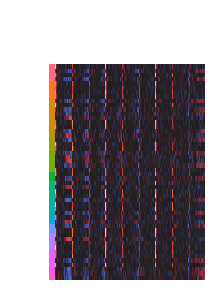

In [86]:
model_data = original_df[original_df.model_id=='n4WsWOO0']
net = Net(n=50,input_size = 2,dale=False)
net.recurrent_layer.weight.data = torch.tensor(model_data['w_rec'].item())
net.recurrent_layer.bias.data = torch.tensor(model_data['bias'].item())
net.input_layer.weight.data = torch.tensor(model_data['w_in'].item())
net.output_layer.weight.data = torch.tensor(model_data['w_out'].item())
variance = model_data['var'].item()
u, z, mask, conditions  = generate_trials(
                            n_trials=100)
x = net(u).detach().cpu().numpy()
rows = []
for k in range(u.shape[0]):
    rows.append({'trial': k,
                 'motion': conditions[k]['motion_coh'],
                 'response': x[k, :, :]})
df = pd.DataFrame(rows)
df = df.groupby('motion').response.apply(lambda r: np.mean(np.stack(r), axis=0)).reset_index()
responses = np.stack(df.response.values)
responses = responses.reshape(-1, responses.shape[2]).T


# Restricting to active neurons
responses = (responses - np.mean(responses, axis=1, keepdims=True)) / np.std(responses, axis=1, keepdims=True)
responses = responses[~np.isnan(responses).any(axis=1)]

responses_jitter = responses + 1*(2*np.random.rand(responses.shape[0],responses.shape[1])-1)



rot = special_ortho_group.rvs(responses.shape[0])
responses = rot @ responses


# pca = PCA(n_components  = 2)
# responses = pca.inverse_transform(pca.fit_transform(responses.T)).T
#k = model_data.k.values[0]
inertia, k= compute_k(responses,n_init=5,max_clusters=25,threshold=.05)
clustering = KMeans(n_clusters=k,n_init=20).fit(responses)
labels  = clustering.labels_
sort = np.argsort(labels)
sorted_responses = responses_jitter[sort,:]
sns.husl_palette(s=.4)
network_pal = sns.husl_palette(pd.Series(np.sort(labels)).unique().size,s=1)
lut = dict(zip(pd.Series(np.sort(labels)).unique(),network_pal))
row_colors = pd.Series(np.sort(labels)).map(lut)
g = sns.clustermap(pd.DataFrame((sorted_responses)),row_cluster=False, col_cluster=False, row_colors=row_colors,figsize=(2.25,3),cbar_pos=None, xticklabels=False, yticklabels=False,center=0)
g.savefig('Figures/SIFigure_nulltest_a.jpg',
    format='jpeg',
    dpi=450,
            bbox_inches='tight'
)

In [87]:
x.shape

(900, 75, 50)

In [88]:
x.shape

(900, 75, 50)

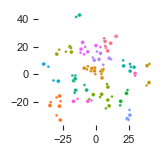

In [89]:

from scipy.stats import special_ortho_group

x_rshp = responses
pca = PCA(n_components=2)
x_proj = pca.fit_transform(x_rshp)
x_proj_jitter = x_proj + 4*(2*np.random.rand(x_proj.shape[0],x_proj.shape[1])-1)

lut = dict(zip(pd.Series(np.sort(labels)).unique(),network_pal))
row_colors = pd.Series(np.sort(labels)).map(lut)

fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
sns.scatterplot(x=x_proj[np.argsort(labels), 0], y=x_proj[np.argsort(labels), 1], c=row_colors,s=8,alpha=1)
sns.scatterplot(x=x_proj_jitter[np.argsort(labels), 0], y=x_proj_jitter[np.argsort(labels), 1], c=row_colors,s=4,alpha=1)
#sns.kdeplot(x=x_proj[np.argsort(labels), 0], y=x_proj[np.argsort(labels), 1], hue = ,s=10,alpha=1)

#ax.scatter(x_proj[np.argsort(labels), 0],x_proj[np.argsort(labels), 1],x_proj[np.argsort(labels), 2],c=row_colors,s=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_tick_params(labelsize=8,bottom=True)
ax.yaxis.set_tick_params(labelsize=8,left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# ax.set_xlim(-15,15)
# ax.set_ylim(-15,15)
plt.savefig('Figures/Fig1c.jpg',
    format='jpeg',
    dpi=450,
            bbox_inches='tight'
)
plt.savefig('Figures/SIFigure_nulltest_b.jpg',
    format='jpeg',
    dpi=450,
            bbox_inches='tight'
)

In [90]:
k

17

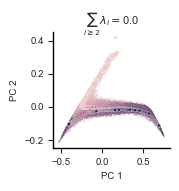

In [82]:

net = Net(n=50,input_size = 2,dale=False)
net.recurrent_layer.weight.data = torch.tensor(model_data['w_rec'].item())
net.recurrent_layer.bias.data = torch.tensor(model_data['bias'].item())
net.input_layer.weight.data = torch.tensor(model_data['w_in'].item())
net.output_layer.weight.data = torch.tensor(model_data['w_out'].item())
palette = sns.color_palette("coolwarm", n_colors=9,as_cmap=False)

u, z, mask, conditions  = generate_trials(
                            n_trials=100)
#net.sigma_in =0.4

#x = net.forward(u).detach().numpy()
x = net(u).detach().numpy()

rot = special_ortho_group.rvs(responses.shape[0])
x =  x @ rot



#x = x + .4 * (2*torch.rand_like(x) - 1)
n_components=3
pca = PCA(n_components=n_components)
pca.fit(x[:,:,:].reshape(-1, x.shape[2]))
x_proj = pca.transform(x.reshape(-1, x.shape[2])).reshape(x.shape[0],x.shape[1],n_components)

rows = []
for k in range(u.shape[0]):
    for t in range(u.shape[1]):
        rows.append({'trial':k,
                     'motion':conditions[k]['motion_coh'],
                    't':t,
                    'z_1':x_proj[k,t,0],
                    'z_2':x_proj[k,t,1],
                     'z_3':x_proj[k,t,2]})
new_df = pd.DataFrame(rows)
new_df_mean =new_df.groupby(['motion','t']).mean().reset_index()
fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
# coherences = np.sort(new_df.motion.unique())
# for i in range(len(coherences)):    
#     motion_df = new_df[new_df.motion == coherences[i]]
#     #ax.plot(motion_df[motion_df.t>=30].z_1.values,motion_df[motion_df.t>=30].z_2.values,color=palette[i],lw=1)
#     ax.plot(motion_df.z_1.values,motion_df.z_2.values,color=palette[i],lw=1)

    # ax.plot(motion_df[motion_df.t<30].z_1.values,motion_df[motion_df.t<30].z_2.values,color='gray',linestyle='--',alpha=.5,lw=1)
#new_df = new_df.groupby(['motion','t']).mean().reset_index()
sns.scatterplot(data=new_df,x='z_1',y='z_2',hue='t',ax=ax,legend=False,s=1,alpha=.25)

sns.scatterplot(data=new_df_mean,x='z_1',y='z_2',hue='t',ax=ax,legend=False,s=4,alpha=1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("PC 1",fontsize=7)
ax.set_ylabel("PC 2",fontsize=7)
ax.set_title(r'$\sum_{i\geq 2}\lambda_i = $'+str(np.round(variance,4)),fontsize=8)
ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
fig.savefig('Figures/Exp_2_Fig_1.jpg',
    format='jpeg',
    dpi=450,
            bbox_inches='tight')


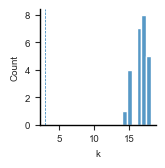

In [99]:
null_k = model_data['null_k'].item()

fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])

sns.histplot(x = null_k)
ax.axvline(3,lw=.5,linestyle='--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("k",fontsize=7)
ax.set_ylabel("Count",fontsize=7)
ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
fig.savefig('Figures/Exp_2_Fig_1.jpg',
    format='jpeg',
    dpi=450,
            bbox_inches='tight')


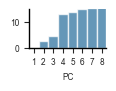

In [104]:
model_data = original_df[original_df.model_id=='n4WsWOO0']
net = Net(n=50,input_size = 2,dale=False)
net.recurrent_layer.weight.data = torch.tensor(model_data['w_rec'].item())
net.recurrent_layer.bias.data = torch.tensor(model_data['bias'].item())
net.input_layer.weight.data = torch.tensor(model_data['w_in'].item())
net.output_layer.weight.data = torch.tensor(model_data['w_out'].item())
variance = model_data['var'].item()
u, z, mask, conditions  = generate_trials(
                            n_trials=100)
x = net(u).detach().numpy()

rot = special_ortho_group.rvs(x.shape[2])
x =  x @ rot
fig = plt.figure(figsize=(1,.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
pca = PCA().fit(x.reshape(-1,x.shape[2]))
sns.barplot(x = np.arange(1,9),y =-np.log(pca.explained_variance_ratio_[:8]),width=1,alpha=.75)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_tick_params(labelsize=6,bottom=True)
ax.yaxis.set_tick_params(labelsize=6,left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

ax.set_xlabel("PC",fontsize=6)
ax.set_ylabel("",fontsize=7)
ax.set_ylim(0,15)
fig.savefig('Figures/Exp_2_Fig_1.jpg',
    format='jpeg',
    dpi=450,
            bbox_inches='tight')